Charles Vin & Aymeric Delefosse <span style="float:right">DAC</span>

# XAI - TME 1 : Explication par génération d'exemples contre-factuels


In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)
from TME1 import GrowingSpheres, plot_boundaries, plot_obs_and_enemy


## Visualisation de la couche sphérique


In [2]:
X, y = make_moons(n_samples=200, shuffle=True, noise=0.05, random_state=0)
X = (X.copy() - X.mean(axis=0)) / X.std(axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = SVC(gamma=1, probability=True)
clf = clf.fit(X_train, y_train)
print(" ### Accuracy:", accuracy_score(y_test, clf.predict(X_test)))


 ### Accuracy: 1.0


Text(0.5, 1.0, 'Spherical Layer')

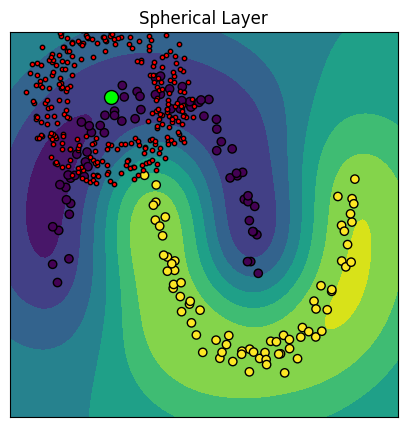

In [3]:
idx = np.random.randint(X_test.shape[0])
obs = X_test[idx, :].reshape(1, -1)

radius = 0.5
step = 0.5
N = 300

GS = GrowingSpheres(clf, 2, N)
GS.predict(obs)
SL = GS.generate_spherical_layer(radius, radius + step)

fig, ax = plt.subplots(figsize=(5, 5))
plot_boundaries(X_train, y_train, ax, clf)
ax.scatter(obs[:, 0], obs[:, 1], marker="o", color="lime", edgecolors="k", s=100)
ax.scatter(SL[:, 0], SL[:, 1], marker="o", color="red", edgecolors="k", s=10)
ax.set_title("Spherical Layer")


On peut vérifier qu'il y a bel et bien des ennemies dans notre couche sphérique :


In [4]:
GS.find_enemy(SL)


True

Et aussi avoir leur nombre :


In [5]:
print(f"## Number of ennemies: {len(GS.enemies)} ({len(GS.enemies) / N * 100:.2f}%)")


## Number of ennemies: 13 (4.33%)


## Expérimentations

### Stabilité

Pour mesurer la variabilité due à la composante aléatoire de l'algorithme, on générera des exemples contrefactueles multiples pour la même observation d'entrée. On pourra également comparer la stabilité de l'algorithme en utilisant différents classifieurs.


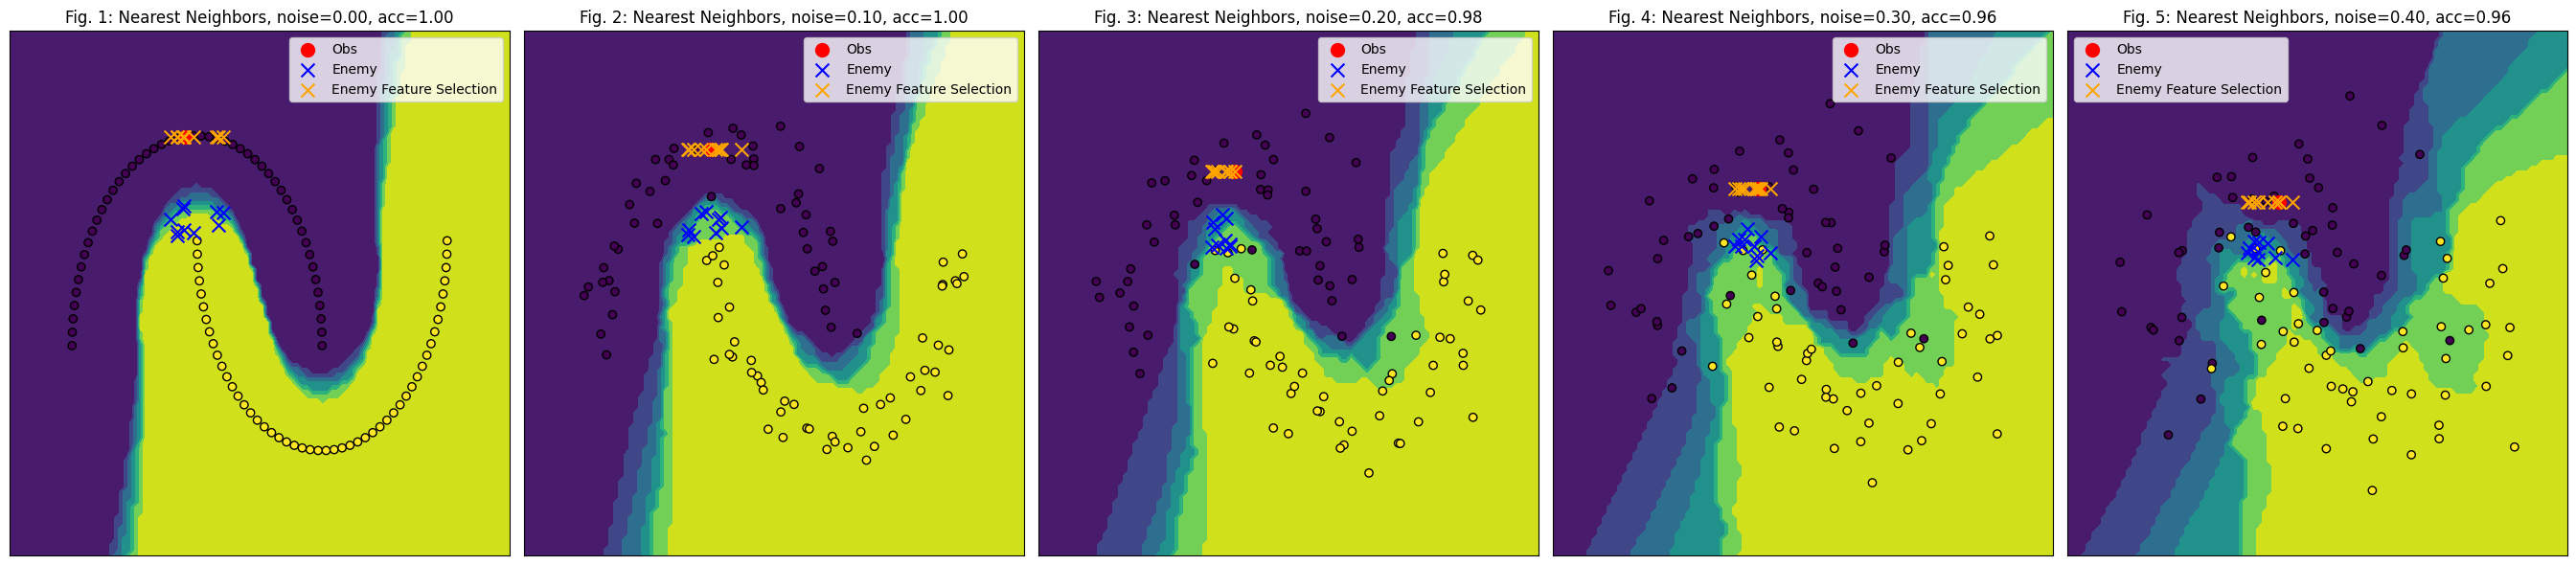

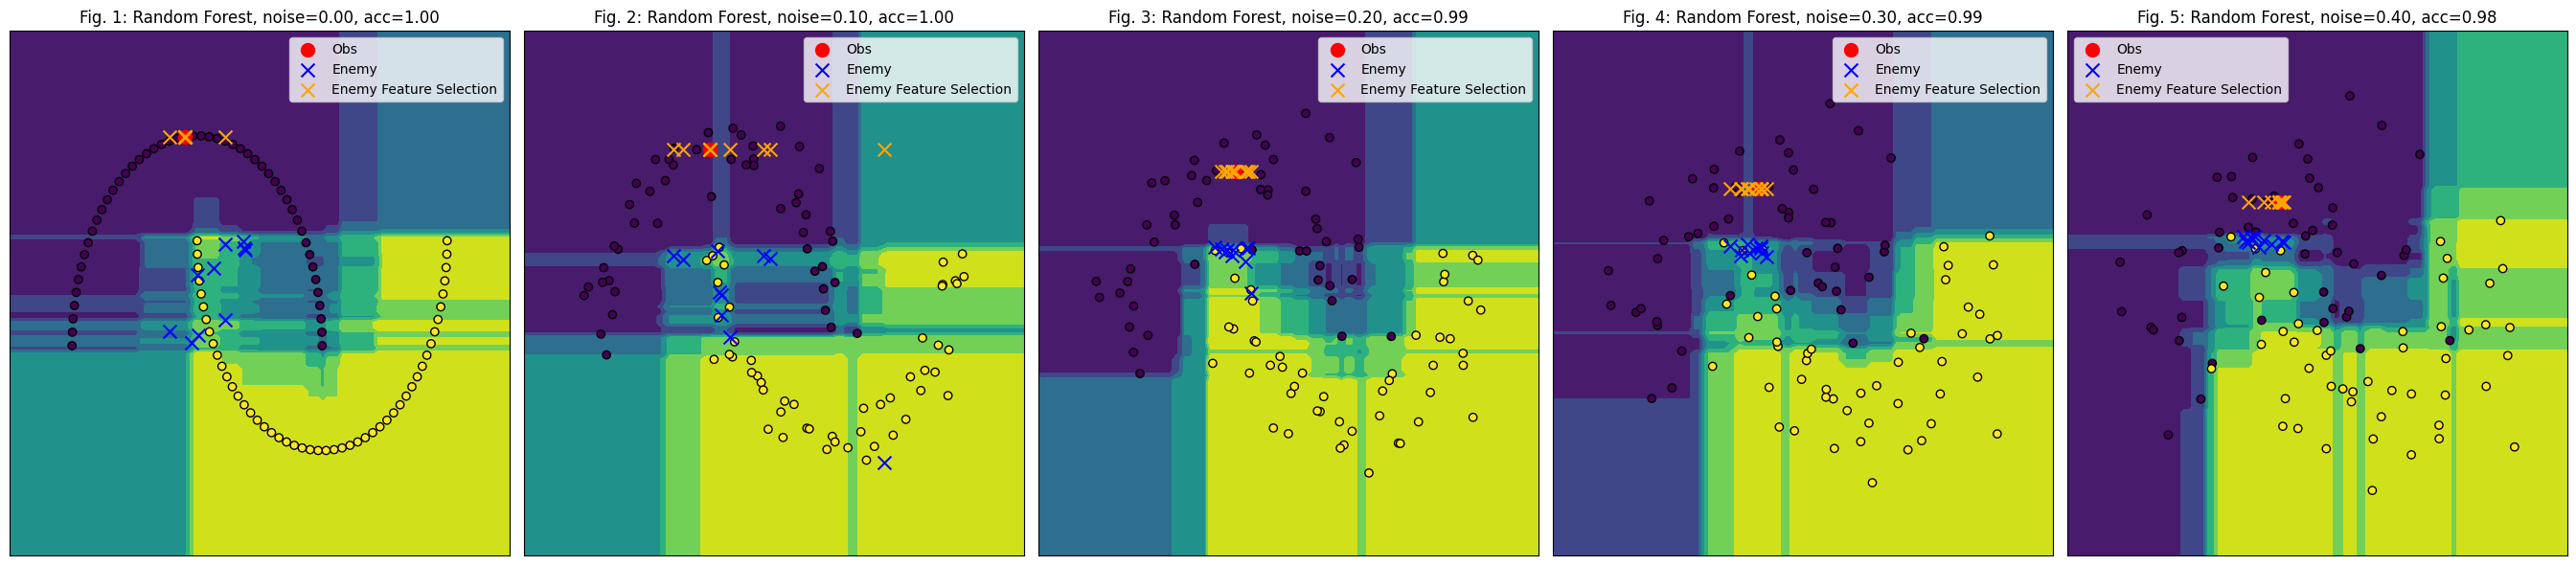

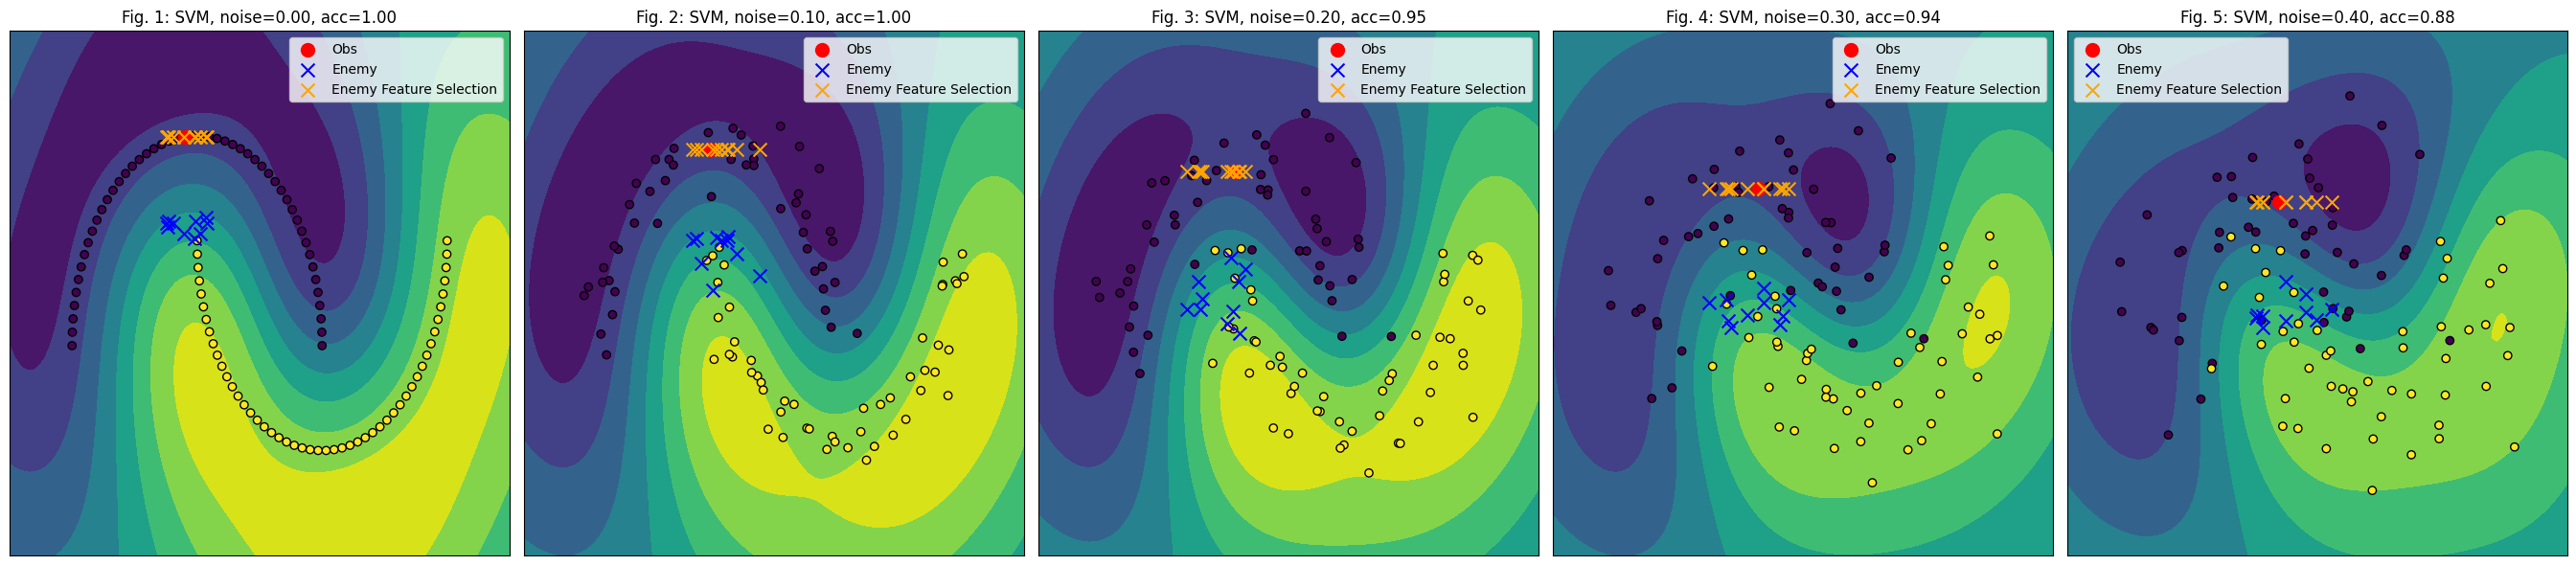

In [6]:
def find_enemies(dataset, clf, n=10, eta=2, n_gs=100):
    X, y = dataset
    obs_to_interpret = X[0]
    clf.fit(X, y)

    enemies = []
    enemies_fs = []
    for _ in range(n):
        gs = GrowingSpheres(clf, eta, n_gs)
        enemy, enemy_fs = gs.predict(obs_to_interpret)
        enemies.append(enemy)
        enemies_fs.append(enemy_fs)

    return enemies, enemies_fs


def visualize(dataset, clf, n=10, eta=2, n_gs=100, ax=None):
    X, y = dataset
    obs_to_interprete = X[0]

    enemies, enemies_fs = find_enemies(dataset, clf, n, eta, n_gs)

    if not ax:
        _, ax = plt.subplots()
    plot_boundaries(X, y, ax, clf)
    ax.scatter(*obs_to_interprete, c="red", marker="o", label="Obs", s=100)

    for enemy, enemy_fs in zip(enemies[:-1], enemies_fs[:-1]):
        ax.scatter(*enemy, c="blue", marker="x", s=100)
        ax.scatter(*enemy_fs, c="orange", marker="x", s=100)
    ax.scatter(*enemies[-1], c="blue", marker="x", label="Enemy", s=100)
    ax.scatter(
        *enemies_fs[-1],
        c="orange",
        marker="x",
        label="Enemy Feature Selection",
        s=100,
    )
    ax.legend()
    return ax


names = [
    "Nearest Neighbors",
    "Random Forest",
    "SVM",
]
classifiers = [
    KNeighborsClassifier(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    SVC(),
]

## Création de jeux de données avec différents niveaux de bruit
datasets = []
noise_lvl = []
for noise in np.arange(0, 0.5, 0.1):
    noise_lvl.append(noise)
    datasets.append(make_moons(noise=noise, random_state=0))

for clf, name in zip(classifiers, names):
    fig = plt.figure(figsize=(27, 6))
    for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
        X, y = dataset
        clf = clf.fit(X, y)
        ax = fig.add_subplot(1, len(datasets), i + 1)
        ax.set_title(
            f"Fig. {i+1}: {name}, noise={noise:.2f}, acc={accuracy_score(y, clf.predict(X)):.2f}"
        )
        visualize(dataset, clf, ax=ax)
    fig.tight_layout()


_Note_ : 10 itérations de Growing Spheres.

Dans l'analyse des résultats de nos itérations pour évaluer l'interprétabilité, il est important de noter que le bruit et la variabilité inhérente aux données peuvent jouer un rôle significatif dans l'apparition d'outliers. Malgré la présence occasionnelle d'outliers et les variations liées au choix du classifieur et au caractère aléatoire de l'algorithme, les résultats agrégés révèlent des tendances cohérentes, ce qui suggère que l'approche globale reste fiable pour interpréter les décisions du modèle. Nous tenons compte de ces éléments dans notre analyse tout en mettant en avant la stabilité globale de l'algorithme dans l'obtention d'explications pertinentes pour les prédictions du modèle. Les ennemis se concentrent tous autour de la frontière de décision.

De plus, la feature selection sélectionne ici une seule caractéristique à la fois, ce qui conduit à un résultat où chaque ennemi ne diffère que par une caractéristique de l'observation, créant une ligne centrée sur l'observation. La sélection de caractéristiques individuelles peut conduire à des explications plus simples et plus faciles à interpréter (parcimonie).

Visualiser c'est bien, mais pourquoi ne pas aller chercher les chiffres et les statistiques pour vraiment comparer notre stabilité. Ainsi, on va chercher à comparer la distance euclidienne (celle de l'algorithme) entre les enemies obtenus et l'observation à interpréter. De plus, pour avoir des résultats statistiquement fiables, on peut se permettre de prendre un nombre d'itérations plus grand ($\geq$ 50) (ici 50).


In [7]:
all_enemy_data = {}

for clf, name in zip(classifiers, names):
    all_enemy_data[name] = {}
    for dataset, noise in zip(datasets, noise_lvl):
        enemy_data, enemy_fs_data = find_enemies(dataset, clf, n=50)

        all_enemy_data[name][noise] = {
            "enemy_data": enemy_data,
            "enemy_fs_data": enemy_fs_data,
        }


In [8]:
import pprint


def compute_distances(data_dict, observation):
    distances = (
        {}
    )  # Create a dictionary to store distances for each classifier and noise level

    for classifier_name, noise_data in data_dict.items():
        distances[classifier_name] = {}  # Create an inner dictionary for the classifier

        for noise_level, data in noise_data.items():
            enemy_data = data["enemy_data"]
            distances[classifier_name][
                noise_level
            ] = []  # Create a list to store distances for this noise level

            # Calculate distances for each run and store them in the list
            for enemy_run in enemy_data:
                run_distances = [
                    np.linalg.norm(observation - enemy, ord=2, axis=1)
                    for enemy in enemy_run
                ]
                distances[classifier_name][noise_level].append(run_distances)

    return distances


def compute_mean_std_distances(data_dict, observation):
    mean_distances = {}  # Dictionary to store mean distances
    std_distances = {}  # Dictionary to store standard deviations of distances

    for classifier_name, noise_data in data_dict.items():
        mean_distances[classifier_name] = {}  # Create inner dictionaries
        std_distances[classifier_name] = {}  # for mean and std

        for noise_level, data in noise_data.items():
            enemy_data = data["enemy_data"]
            distances = []  # List to store distances for this noise level

            # Calculate distances for each run and store them in the list
            for enemy_run in enemy_data:
                run_distances = [
                    np.linalg.norm(observation - enemy) for enemy in enemy_run
                ]
                distances.extend(run_distances)  # Extend the list with distances

            # Calculate mean and standard deviation for this noise level
            mean_distances[classifier_name][noise_level] = np.mean(distances)
            std_distances[classifier_name][noise_level] = np.std(distances)

    return mean_distances, std_distances


distances = compute_distances(all_enemy_data, obs)
mean_distances, std_distances = compute_mean_std_distances(all_enemy_data, obs)

# Now you have mean and std distances organized by classifier name and noise level
pprint.pprint(mean_distances)
pprint.pprint(std_distances)


{'Nearest Neighbors': {0.0: 1.8692635183167423,
                       0.1: 1.8691404226819557,
                       0.2: 1.8760771690892264,
                       0.30000000000000004: 1.868249376254959,
                       0.4: 1.8667636826340936},
 'Random Forest': {0.0: 1.8216617586440196,
                   0.1: 1.9383441208614132,
                   0.2: 1.8361283700169044,
                   0.30000000000000004: 1.8248092766241857,
                   0.4: 1.8687984079779423},
 'SVM': {0.0: 1.8688338370294966,
         0.1: 1.8427668106276667,
         0.2: 1.8347578271523188,
         0.30000000000000004: 1.82613390914887,
         0.4: 1.823031140866485}}
{'Nearest Neighbors': {0.0: 0.04232348348737193,
                       0.1: 0.043733468635023254,
                       0.2: 0.052462790863279034,
                       0.30000000000000004: 0.050484254189858906,
                       0.4: 0.04538888959026962},
 'Random Forest': {0.0: 0.021247297767316826,
            

In [9]:
import scipy.stats as stats

# Iterate over classifiers and noise levels
for classifier_name, noise_data in distances.items():
    for noise_level, distances_for_classifier in noise_data.items():
        # Perform the ANOVA test
        f_statistic, p_value = stats.f_oneway(*distances_for_classifier)

        # Check and print the results
        if p_value < 0.05:
            print(f"Classifier: {classifier_name}, Noise Level: {noise_level:.2f}")
            print(
                f"ANOVA result: Significant differences detected (p-value = {p_value[0]:.4f})"
            )
            print()
        else:
            print(f"Classifier: {classifier_name}, Noise Level: {noise_level:.2f}")
            print(
                f"ANOVA result: No significant differences detected (p-value = {p_value[0]:.4f})"
            )
            print()


Classifier: Nearest Neighbors, Noise Level: 0.00
ANOVA result: No significant differences detected (p-value = 1.0000)

Classifier: Nearest Neighbors, Noise Level: 0.10
ANOVA result: No significant differences detected (p-value = 1.0000)

Classifier: Nearest Neighbors, Noise Level: 0.20
ANOVA result: No significant differences detected (p-value = 1.0000)

Classifier: Nearest Neighbors, Noise Level: 0.30
ANOVA result: No significant differences detected (p-value = 1.0000)

Classifier: Nearest Neighbors, Noise Level: 0.40
ANOVA result: No significant differences detected (p-value = 1.0000)

Classifier: Random Forest, Noise Level: 0.00
ANOVA result: Significant differences detected (p-value = 0.0351)

Classifier: Random Forest, Noise Level: 0.10
ANOVA result: Significant differences detected (p-value = 0.0194)

Classifier: Random Forest, Noise Level: 0.20
ANOVA result: No significant differences detected (p-value = 0.9999)

Classifier: Random Forest, Noise Level: 0.30
ANOVA result: No sign

### Autre jeu de données artificielle

Ici `make_circles` qui génére des cercles en 2D.


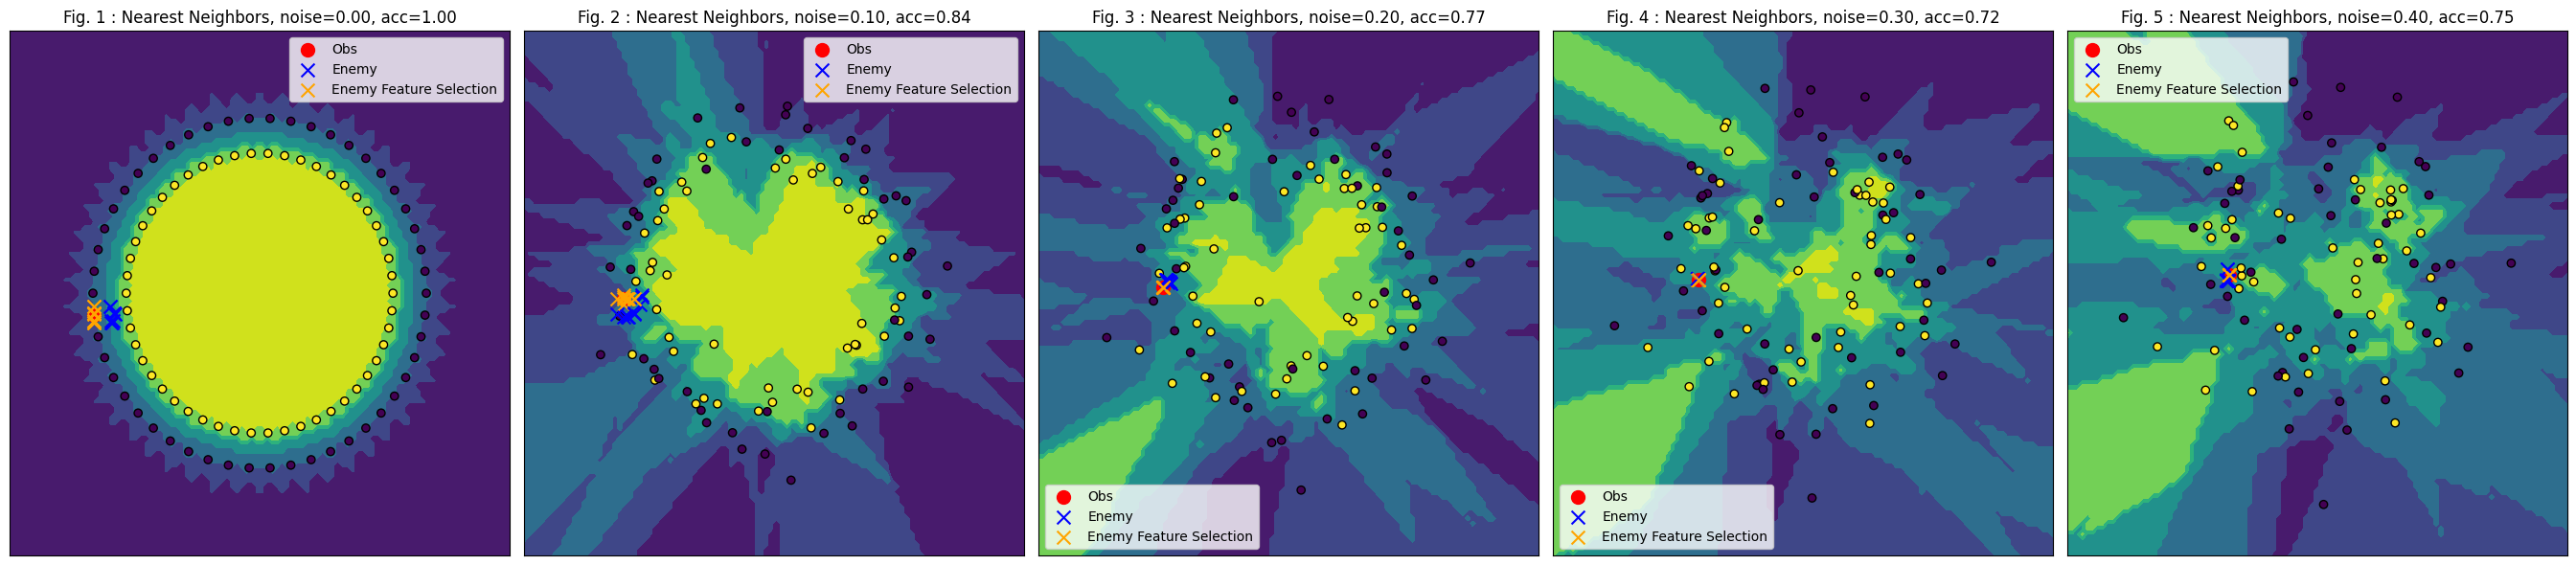

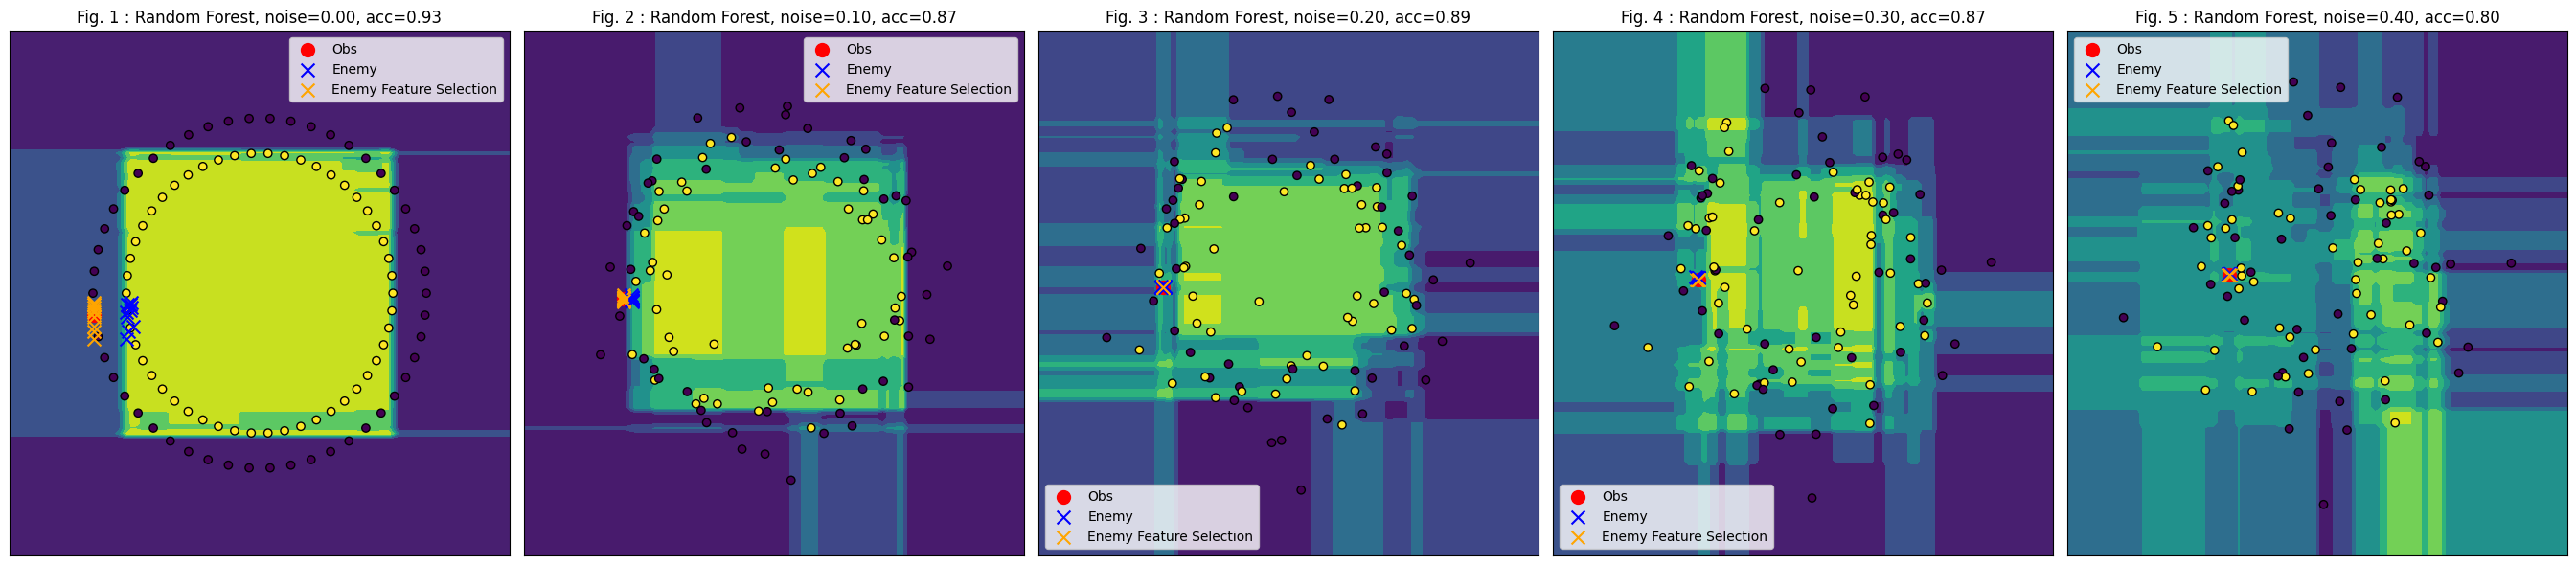

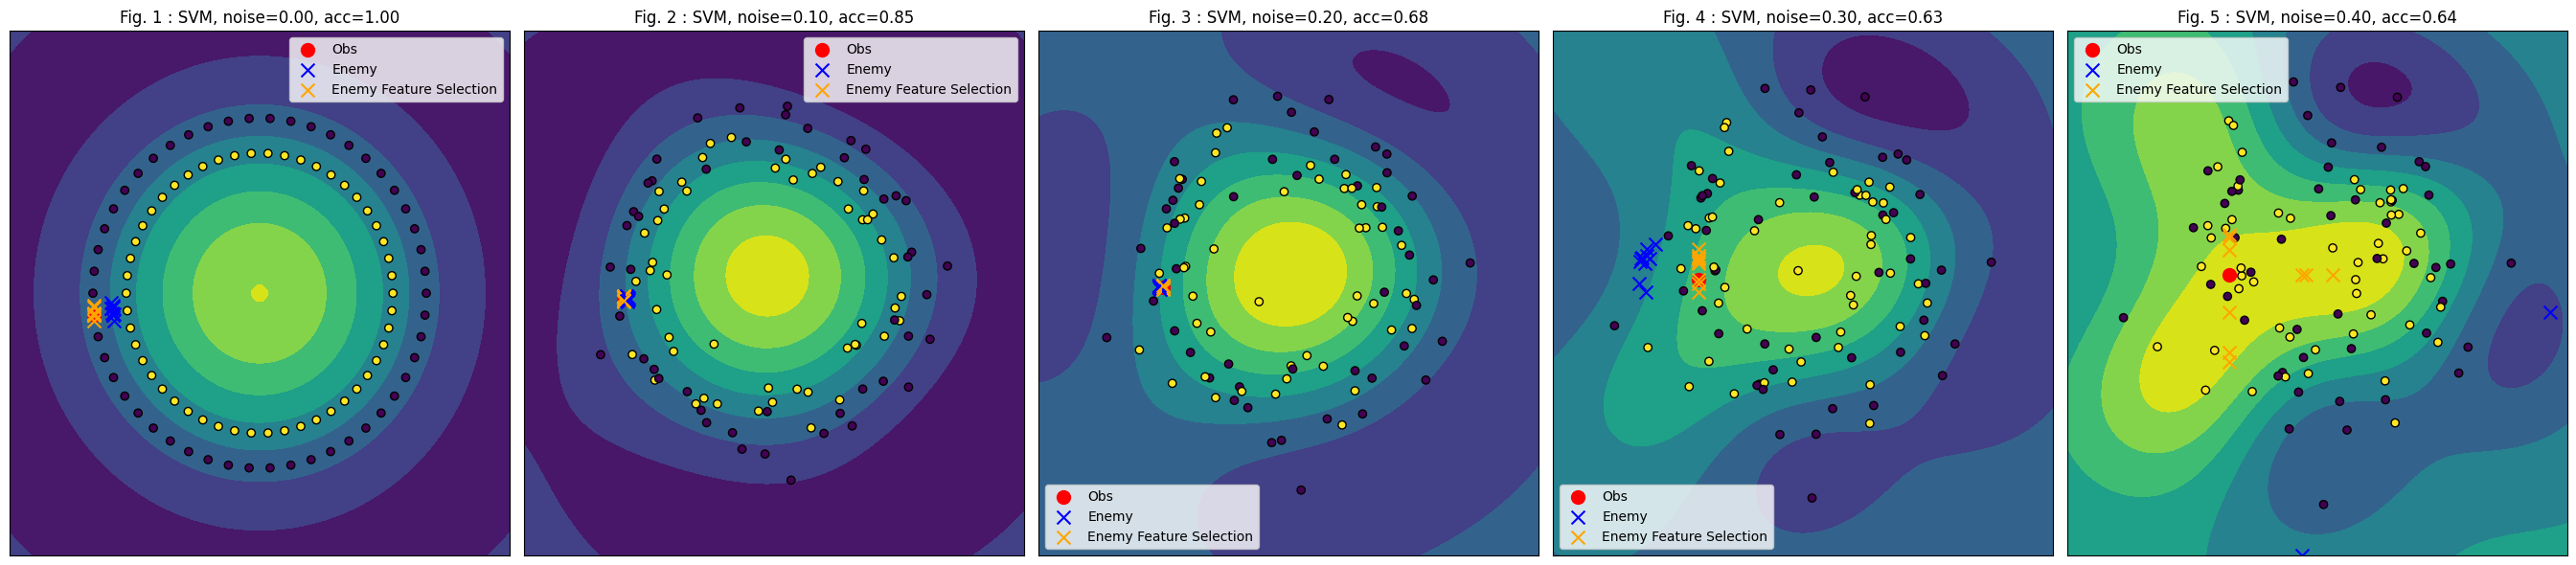

In [10]:
from sklearn.datasets import make_circles

datasets = []
noise_lvl = []
for noise in np.arange(0, 0.5, 0.1):
    noise_lvl.append(noise)
    datasets.append(make_circles(noise=noise, random_state=0))
for clf, name in zip(classifiers, names):
    fig = plt.figure(figsize=(27, 6))
    for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
        X, y = dataset
        clf = clf.fit(X, y)
        ax = fig.add_subplot(1, len(datasets), i + 1)
        ax.set_title(
            f"Fig. {i+1} : {name}, noise={noise:.2f}, acc={accuracy_score(y, clf.predict(X)):.2f}"
        )
        visualize(dataset, clf, ax=ax)
    fig.tight_layout()


Les points sont ici très centrés atour d'eux-mêmes, nous supposons que cela est principalement dû au fait que nos données sont des cercles et que notre couche sphérique également.

Cependant, on voit un phénomène apparaître sur notre dernière figure, dès que la précision de notre classifieur devient faible, alors la performance de notre algorithme également. Il serait intéressant de pousser la recherche plus loin pour étudier s'il y a effectivement une corrélation entre performance du classifieur et performance de l'algorithme (si le temps nous le permettait). La prochaine section confirmera cette hypothèse.

### Données classiques
#### Prêts bancaires

> L'expérimentation suivante n'a pas abouti en raison de la performance insatisfaisante du classifieur pour l'une des classes.

Pendant le cours, nous avons particulièrement utilisé l'exemple de l'éligibilité aux prêts bancaires. Nous proposons donc d'utiliser cet exemple pour tester Growing Sphere sur des données réelles. Le jeu de données est accessible à l'adresse suivante : https://www.kaggle.com/datasets/burak3ergun/loan-data-set.

Récapitulatif des variables (_features_) constituant notre jeu de données :

- `Variable`: Description
- `Loan_ID`: Unique Loan ID
- `Gender`: Male/ Female
- `Married`: Applicant married (Y/N)
- `Dependents`: Number of dependents
- `Education`: Applicant Education (Graduate/ Under Graduate)
- `Self_Employed`: Self employed (Y/N)
- `ApplicantIncome`: Applicant income
- `CoapplicantIncome`: Coapplicant income
- `LoanAmount`: Loan amount in thousands
- `Loan_Amount_Term`: Term of loan in months
- `Credit_History`: Credit history meets guidelines
- `Property_Area`: Urban/ Semi Urban/ Rural
- `Loan_Status`: Loan approved (Y/N)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE


df = pd.read_csv("loan_data_set.csv").drop(columns=["Loan_ID"])  # .dropna()
df["Gender"].fillna(df["Gender"].mode()[0], inplace=True)
df["Married"].fillna(df["Married"].mode()[0], inplace=True)
df["Dependents"].fillna(df["Dependents"].mode()[0], inplace=True)
df["Self_Employed"].fillna(df["Self_Employed"].mode()[0], inplace=True)
df["Credit_History"].fillna(df["Credit_History"].mode()[0], inplace=True)
df["Loan_Amount_Term"].fillna(df["Loan_Amount_Term"].mode()[0], inplace=True)
df["LoanAmount"].fillna(df["LoanAmount"].mean(), inplace=True)

df = pd.get_dummies(df).drop(
    [
        "Gender_Female",
        "Married_No",
        "Education_Not Graduate",
        "Self_Employed_No",
        "Loan_Status_N",
    ],
    axis=1,
)
new = {
    "Gender_Male": "Gender",
    "Married_Yes": "Married",
    "Education_Graduate": "Education",
    "Self_Employed_Yes": "Self_Employed",
    "Loan_Status_Y": "Loan_Status",
}
df.rename(columns=new, inplace=True)

# Q1 = df.quantile(0.25, numeric_only=True)
# Q3 = df.quantile(0.75, numeric_only=True)
# IQR = Q3 - Q1
# df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

df.ApplicantIncome = np.sqrt(df.ApplicantIncome)
df.CoapplicantIncome = np.sqrt(df.CoapplicantIncome)
df.LoanAmount = np.sqrt(df.LoanAmount)

X = df.drop(["Loan_Status"], axis=1)
y = df["Loan_Status"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
mmt = MinMaxScaler()
X_train = mmt.fit_transform(X_train)
X_test = mmt.transform(X_test)


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

clf = RandomForestClassifier(n_estimators=1000, random_state=1, max_leaf_nodes=18)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
no = y_train == 0
no_test = y_test == 0

accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, clf.predict(X_train))
accuracy_train_no = accuracy_score(y_train[no], clf.predict(X_train[no]))
accuracy_test_no = accuracy_score(y_test[no_test], clf.predict(X_test[no_test]))
print(f"Précision en test : {accuracy_test:.4f}")
print(f"Précision en train  : {accuracy_train:.4f}")
print(f"Précision en train pour la classe négative : {accuracy_train_no:.4f}")
print(f"Précision en test pour la classe négative : {accuracy_test_no:.4f}")


Précision en test : 0.8049
Précision en train  : 0.8705
Précision en train pour la classe négative : 0.7590
Précision en test pour la classe négative : 0.4242


Après de nombreuses itérations et analyses, la prédiction de la classe négative reste difficile nos efforts. Les résultats montrent une précision globale de 0.80 pour le jeu de test, mais la précision pour la classe négative demeure très faible à 0.42.

---


In [13]:
idx = 1
obs_to_interprete = X_train[idx]
y_train[idx], pd.Series(obs_to_interprete, index=X.columns)


(False,
 ApplicantIncome            0.344468
 CoapplicantIncome          0.000000
 LoanAmount                 0.468933
 Loan_Amount_Term           0.729730
 Credit_History             1.000000
 Gender                     1.000000
 Married                    0.000000
 Dependents_0               0.000000
 Dependents_1               1.000000
 Dependents_2               0.000000
 Dependents_3+              0.000000
 Education                  1.000000
 Self_Employed              0.000000
 Property_Area_Rural        0.000000
 Property_Area_Semiurban    1.000000
 Property_Area_Urban        0.000000
 dtype: float64)

Le premier exemple des données d'apprentissage représente une personne s'étant vu son prêt refusé. 

In [14]:
def display_countefactual(gs, X, idx, diff=False):
    enemy, enemy_fs = gs.predict(obs_to_interprete)
    print("Prédiction de l'observation brute :            ", clf.predict(obs_to_interprete.reshape(1, -1)))
    print("Prédiction de l'ennemi :                       ", clf.predict(enemy.reshape(1, -1)))
    print("Prédiction de l'ennemi avec feature selection :", clf.predict(enemy_fs.reshape(1, -1)))
    enemy = pd.Series(enemy, index=X.columns, name="enemy")
    enemy_fs = pd.Series(enemy_fs, index=X.columns, name="enemy_fs")
    difference = pd.Series(enemy_fs - X.loc[idx], name="enemy_fs - obs")
    if diff:
        return pd.DataFrame([X.loc[idx].rename('obs_to_interprete'), enemy_fs, enemy, difference], columns=X.columns)
    else:
        return pd.DataFrame([pd.Series(obs_to_interprete, index=X.columns, name="obs to interprete"), enemy_fs, enemy], columns=X.columns)


display_countefactual(GrowingSpheres(clf, 2, 100), X, idx)

Prédiction de l'observation brute :             [ True]
Prédiction de l'ennemi :                        [False]
Prédiction de l'ennemi avec feature selection : [ True]


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education,Self_Employed,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
obs to interprete,0.344468,0.000000,0.468933,0.729730,1.00000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
enemy_fs,0.344528,-0.000098,0.468568,0.729376,1.00000,1.000011,0.000039,-0.000314,0.999776,0.000066,0.000111,0.999749,-0.000028,0.000168,1.000306,-0.000123
enemy,0.344528,-0.000098,0.468568,0.729376,0.99945,1.000011,0.000039,-0.000314,0.999776,0.000066,0.000111,0.999749,-0.000028,0.000168,1.000306,-0.000123


Dès le début, nous constatons que le point que nous cherchons à interpréter est mal classifié. L'ennemi généré est donc assigné à l'autre classe, ce qui est en contradiction avec sa véritable classe.

Il est également important de noter que notre algorithme de Growing Sphere semble moins adapté à la classification binaire. Une approche consiste à arrondir les valeurs à un ou zéro à partir de $\frac{1}{2}$.

Dans l'ensemble, il peut être judicieux de passer à un ensemble de données plus simple pour simplifier notre approche.

---


#### Enquête de satisfaction des passagers d'une compagnie aérienne

This dataset contains an airline passenger satisfaction survey (https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction).

Variables:
* `Gender`: Gender of the passengers (Female, Male)
* `Customer Type`: The customer type (Loyal customer, disloyal customer)
* `Age`: The actual age of the passengers
* `Type of Travel`: Purpose of the flight of the passengers (Personal Travel, Business Travel)
* `Class`: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
* `Flight distance`: The flight distance of this journey
* `Inflight wifi service`: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
* `Departure/Arrival time convenient`: Satisfaction level of Departure/Arrival time convenient
* `Ease of Online booking`: Satisfaction level of online booking
* `Gate location`: Satisfaction level of Gate location
* `Food and drink`: Satisfaction level of Food and drink
* `Online boarding`: Satisfaction level of online boarding
* `Seat comfort`: Satisfaction level of Seat comfort
* `Inflight entertainment`: Satisfaction level of inflight entertainment
* `On-board service`: Satisfaction level of On-board service
* `Leg room service`: Satisfaction level of Leg room service
* `Baggage handling`: Satisfaction level of baggage handling
* `Check-in service`: Satisfaction level of Check-in service
* `Inflight service`: Satisfaction level of inflight service
* `Cleanliness`: Satisfaction level of Cleanliness
* `Departure Delay in Minutes`: Minutes delayed when departure
* `Arrival Delay in Minutes`: Minutes delayed when Arrival
* `Satisfaction`: Airline satisfaction level (Satisfaction, neutral or dissatisfaction)

Note : Les caractéristiques catégorielles ne seront pas utilisées.

In [15]:
df_train = pd.read_csv("train.csv").dropna()
df_test = pd.read_csv("test.csv").dropna()

features = [
    # "Gender",
    # "Customer Type",
    "Age",
    # "Type of Travel",
    # "Class",
    "Flight Distance",
    "Inflight wifi service",
    "Departure/Arrival time convenient",
    "Ease of Online booking",
    "Gate location",
    "Food and drink",
    "Online boarding",
    "Seat comfort",
    "Inflight entertainment",
    "On-board service",
    "Leg room service",
    "Baggage handling",
    "Checkin service",
    "Inflight service",
    "Cleanliness",
    "Departure Delay in Minutes",
    "Arrival Delay in Minutes",
]
target = ["satisfaction"]

# Split into test and train
oh = OneHotEncoder(handle_unknown="ignore")
# X_train = oh.fit_transform(df_train[features])
# X_test = oh.transform(df_test[features])
X_train = df_train[features]
X_test = df_test[features]
y_train = df_train[target].replace({"satisfied": 1, "neutral or dissatisfied": 0})
y_test = df_test[target].replace({"satisfied": 1, "neutral or dissatisfied": 0})

# Normalize Features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


## ROC AUC = 0.9464

              precision    recall  f1-score   support

           0    0.94315   0.96724   0.95504     14528
           1    0.95670   0.92547   0.94083     11365

    accuracy                        0.94891     25893
   macro avg    0.94993   0.94635   0.94794     25893
weighted avg    0.94910   0.94891   0.94880     25893



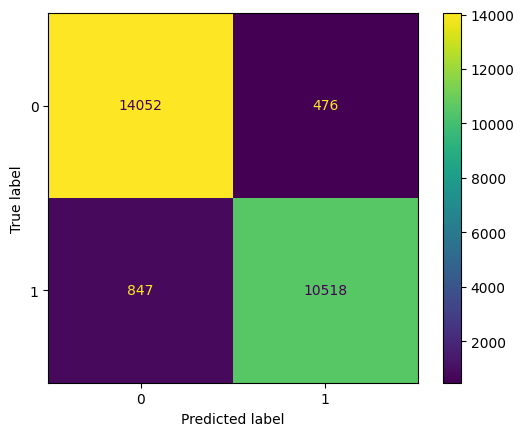

In [16]:
warnings.simplefilter('ignore')
params_rf = {
    "max_depth": 25,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "n_estimators": 100,
    "random_state": 42,
    "n_jobs": -1,
}


def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"## ROC AUC = {roc_auc:.4f}")
    print()
    print(classification_report(y_test, y_pred, digits=5))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    return model, roc_auc


clf = RandomForestClassifier(**params_rf)
clf, roc_auc_rf = run_model(clf, X_train, y_train, X_test, y_test)


Voilà un estimateur qui fonctionne !


In [17]:
idx = 1
obs_to_interprete = X_train.loc[idx].to_numpy()
df_train.loc[idx, features], df_train.loc[idx, target]


(Age                                   25
 Flight Distance                      235
 Inflight wifi service                  3
 Departure/Arrival time convenient      2
 Ease of Online booking                 3
 Gate location                          3
 Food and drink                         1
 Online boarding                        3
 Seat comfort                           1
 Inflight entertainment                 1
 On-board service                       1
 Leg room service                       5
 Baggage handling                       3
 Checkin service                        1
 Inflight service                       4
 Cleanliness                            1
 Departure Delay in Minutes             1
 Arrival Delay in Minutes             6.0
 Name: 1, dtype: object,
 satisfaction    neutral or dissatisfied
 Name: 1, dtype: object)

Voici un passager `neutral or dissatisfied`.

In [18]:
warnings.simplefilter('ignore')
display_countefactual(GrowingSpheres(clf, 2, 100), X_train, idx, True)


Prédiction de l'observation brute :             [0]
Prédiction de l'ennemi :                        [1]
Prédiction de l'ennemi avec feature selection : [0]


,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
obs_to_interprete,25.000000,235.000000,3.000000,2.000000,3.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,5.000000,3.000000,1.000000,4.000000,1.00000,1.000000,6.00000
enemy_fs,25.932304,234.360177,3.000000,1.767861,2.522278,1.485645,0.767313,4.114402,0.612261,0.092352,0.531364,4.443808,4.185334,0.346959,3.543581,1.07851,1.687057,4.92009
enemy,25.932304,234.360177,5.208281,1.767861,2.522278,1.485645,0.767313,4.114402,0.612261,0.092352,0.531364,4.443808,4.185334,0.346959,3.543581,1.07851,1.687057,4.92009
enemy_fs - obs,0.932304,-0.639823,0.000000,-0.232139,-0.477722,-1.514355,-0.232687,1.114402,-0.387739,-0.907648,-0.468636,-0.556192,1.185334,-0.653041,-0.456419,0.07851,0.687057,-1.07991


En fonction des différentes exécutions, l'exemple contrefactuel généré en sortie est parfois correctement interprétable. Cependant, il arrive qu'il attribue de moins bonnes notes à certaines catégories, alors que l'intuition suggère le contraire.

En effet, pour qu'un client soit plus satisfait, il serait logique qu'il attribue de meilleures notes à chaque catégorie. Par conséquent, la dernière ligne du tableau précédent, qui représente la différence entre l'ennemi généré (`enemy_fs`) et l'observation initiale (`obs`), devrait généralement afficher des chiffres positifs, à l'exception des retards.

> On pourrait supposer que si ce client avait eu un peu moins de retard, ses notes auraient peut-être été positives (et il aurait été un client satisfié de la compagnie aérienne).

Dans un contexte plus concret, les résultats de l'algorithme Growing Spheres semblent parfois plus aléatoires dans les interprétations fournies. Pour illustrer davantage ce phénomène, voici d'autres résultats d'exécutions.

In [19]:
warnings.simplefilter('ignore')
display_countefactual(GrowingSpheres(clf, 2, 100), X_train, idx, True)


Prédiction de l'observation brute :             [0]
Prédiction de l'ennemi :                        [1]
Prédiction de l'ennemi avec feature selection : [0]


,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
obs_to_interprete,25.000000,235.000000,3.000000,2.000000,3.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,5.000000,3.000000,1.000000,4.000000,1.000000,1.000000,6.000000
enemy_fs,25.000000,234.572605,3.000000,1.292621,1.573216,2.497443,0.936718,3.036532,0.315361,-0.088089,0.598904,4.563068,3.464165,1.853845,3.578822,1.404541,0.624594,6.960226
enemy,26.848155,234.572605,4.504093,1.292621,1.573216,2.497443,0.936718,3.036532,0.315361,-0.088089,0.598904,4.563068,3.464165,1.853845,3.578822,1.404541,0.624594,6.960226
enemy_fs - obs,0.000000,-0.427395,0.000000,-0.707379,-1.426784,-0.502557,-0.063282,0.036532,-0.684639,-1.088089,-0.401096,-0.436932,0.464165,0.853845,-0.421178,0.404541,-0.375406,0.960226


In [20]:
warnings.simplefilter('ignore')
display_countefactual(GrowingSpheres(clf, 2, 100), X_train, idx, True)


Prédiction de l'observation brute :             [0]
Prédiction de l'ennemi :                        [1]
Prédiction de l'ennemi avec feature selection : [0]


,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
obs_to_interprete,25.00000,235.000000,3.000000,2.000000,3.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,5.000000,3.000000,1.000000,4.000000,1.000000,1.00000,6.000000
enemy_fs,24.85996,233.676992,3.000000,1.470819,2.631913,2.784659,0.533704,3.662138,-0.144896,0.970845,1.126104,5.848222,2.610375,1.847449,4.095935,0.643525,1.97054,5.950838
enemy,24.85996,233.676992,5.856856,1.470819,2.631913,2.784659,0.533704,3.662138,-0.144896,0.970845,1.126104,5.848222,2.610375,1.847449,4.095935,0.643525,1.97054,5.950838
enemy_fs - obs,-0.14004,-1.323008,0.000000,-0.529181,-0.368087,-0.215341,-0.466296,0.662138,-1.144896,-0.029155,0.126104,0.848222,-0.389625,0.847449,0.095935,-0.356475,0.97054,-0.049162
